# CoreMorph


In the basic algorithm, the graph fragments that make up the grammar are defined by a rootnode, a radius and a thickness. 
A fragment is called a $CIP_{radius}^{thickness}(root)$. The core is made up of all the nodes in a certain radius around the root. Interface part is 
the subgraph induced by every node in distance radius+thickness arround the root minus nodes in the core.


Here, we generate a graph minor (by contracting edges) for any given input graph. We extract the CIP from the graph minor.  Due to the contraction 
one node in the minor may represent any number of nodes in the unaltered graph. 
once we have the core in the unaltered graph, we can consider all nodes in THICKNES distance to this core and obtain a new interface. 

Core and interface of the unaltered graph are saved in the grammar.
There is still unused information in the interface of the minor graph. In the congruency check that will tell is if two CIPs are exchangeable, we not only check the unaltered graph interface but also the minor graphs interface. We hope that this will increase the score of the resulting applications of productions.

#### initialise nb

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from eden.util import configure_logging
import logging

DEBUG=True
NJOBS=4
if DEBUG: NJOBS=1

configure_logging(logging.getLogger(),verbosity=1+DEBUG)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

# data source, see introduction for info.
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname='../toolsdata/bursi.pos.gspan', size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

# Meet the GraphTransformer (and the decomposer)

A graph transformer in general is used in two stages of the sampling process.
First on an incoming graph to make it graphlearnable. Then, after a graph was changed, it might get 
retransformed.
An example of this might be an RNA molecule that one wishes to refold after changing parts of the secondary structure graph.

The decomposer is the interface between graphs and graphlearn.
It is conducting substitutions of CIPs and extract CIPs from the graph.


As long as the decomposer is delivering acceptable data, the sampler will not care what the graph looks like.
It might not exist at all or have this second minorgraph version working in the background.


### Data Defined Transformation
In this first example, the graphminor generation is learned.
We do this by using the (one class) estimator to annotate the nodes in the graph, then the graph is contracted
on nodes with similar scores.
The subgraphs obtained in this way are then clustered and the clustername is used for the names of the parts.



Classifier:
SGDClassifier(alpha=0.000570765195782, average=False, class_weight=None,
       epsilon=0.1, eta0=0.68809151091, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', n_iter=11, n_jobs=1,
       penalty='l2', power_t=0.447511915292, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000
learning abstraction: 436 partial graphs found
num clusters: 5
class: 0 count:154 (0.35)
class: 1 count:54 (0.12)
class: 2 count:119 (0.27)
class: 3 count:33 (0.08)
class: 4 count:28 (0.06)
class: 5 count:48 (0.11)



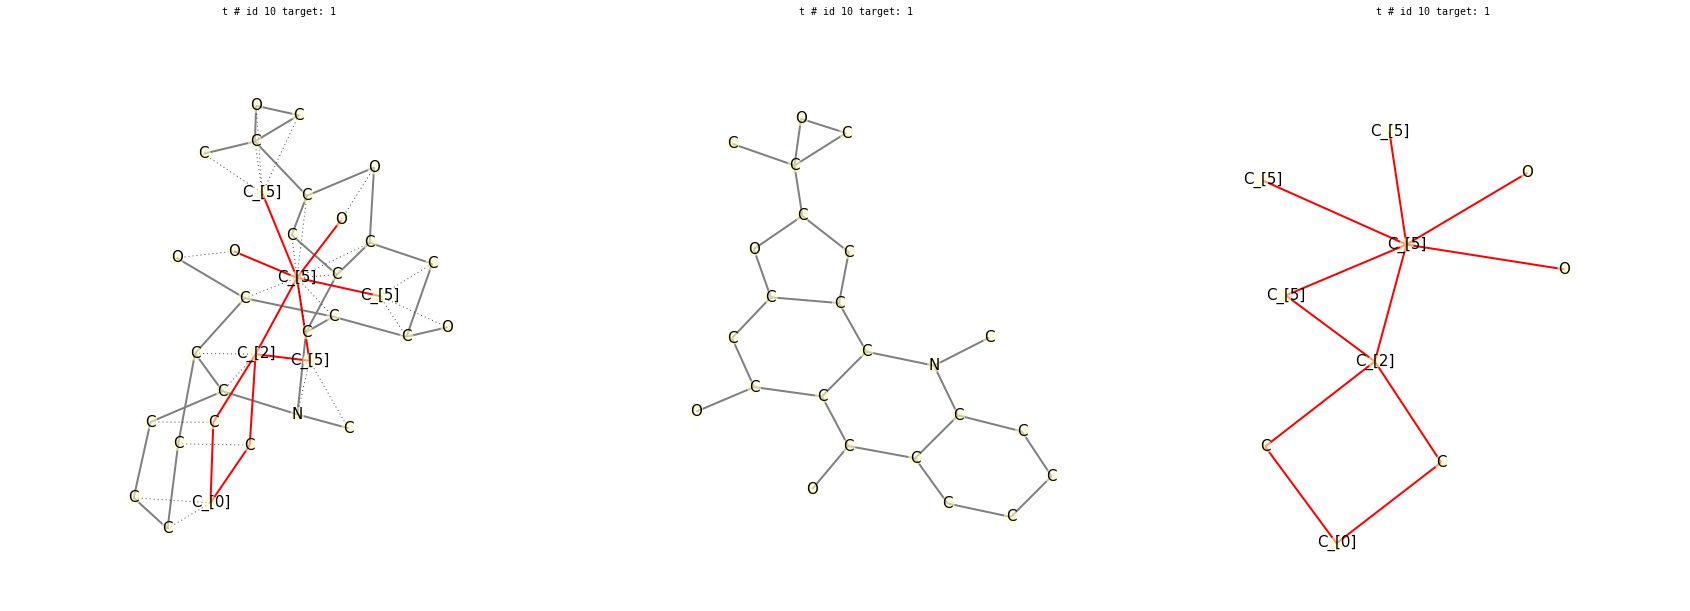

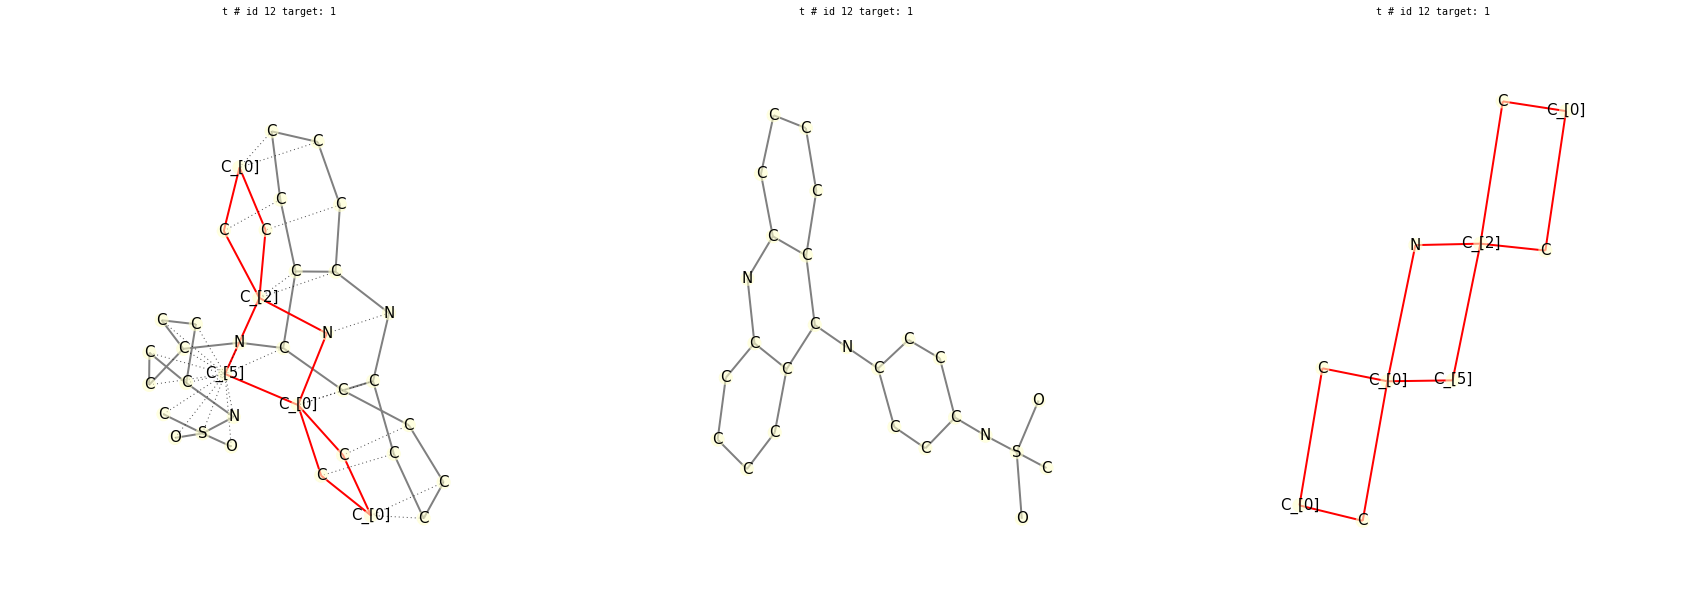

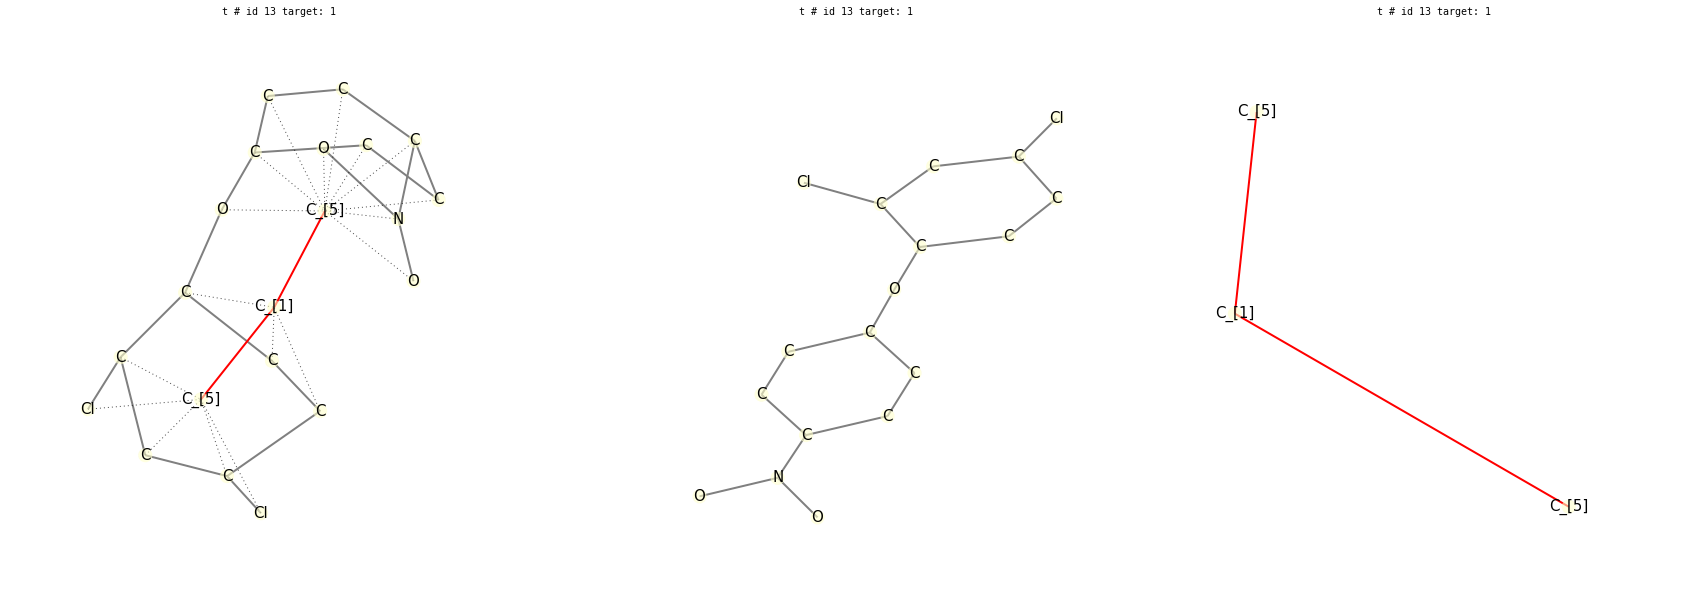

In [2]:
from graphlearn.utils import selectdraw
import graphlearn.minor.transform as transform
import graphlearn.minor.decompose as decompose
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans 
from eden.graph import Vectorizer
import math
#preparing
decomposer = decompose.MinorDecomposer(include_base=False, base_thickness_list=[2])

# nodes in all graphs get scored.
# the default functionality is to take all scores and cluster them 
# such that nodes that get assigned the same cluster can be contracted in a minor graph.
# ShapeCluster is going the lazy route and uses the score of the node directly for the clusterid 
class ShapeCluster:
    def fit(self,li):
        pass
    def predict(self,i):
        return [math.ceil(i)]

pp=transform.GraphMinorTransformer(#core_shape_cluster =KMeans(n_clusters=4),
                                   core_shape_cluster =ShapeCluster(),
                                   name_cluster       =MiniBatchKMeans(n_clusters=6), 
                                   save_graphclusters =True,
                                   shape_score_threshold=2.5,
                                   shape_min_size=2)



# the magic happens here
decomposers=[decomposer.make_new_decomposer(Vectorizer(),x) for x in pp.fit_transform(get_graphs(size=200))]

# lets look at some clusters
if False:
    for cluster_id in pp.graphclusters:
        print('cluster id: %d  num: %d' % (cluster_id, len(pp.graphclusters[cluster_id])))
        if cluster_id != -1:
            selectdraw(pp.graphclusters[cluster_id][:7], n_graphs_per_line=7, 
                            size=6, vertex_color='_label_', prog='neato', colormap='Set3',
                            contract=False,edge_label='label')


#lets draw what we did there
for i in range(3):
    selectdraw([decomposers[i+5].pre_vectorizer_graph(nested=True),decomposers[i+5].base_graph(),decomposers[i+5].abstract_graph()],
                    size=10,
                    contract=True, 
                    abstract_color='red',
                    vertex_label='label',nesting_edge_alpha=0.7)

    
# confirming that cores of CIPs look interesting now:
if False:
    #parameters 
    radius_list=[0,2]
    thickness_list=[2,4]
    base_thickness_list=[2]
    #extract
    cips=decomposers[0].all_core_interface_pairs(thickness_list=[2],radius_list=[0,1],hash_bitmask=2**20-1)
    draw.graphlearn([cips[0][0].graph,cips[0][1].graph], contract=False)


# User Defined GraphTransformer

Here we see another example of a way to generate a graph minor.

Since we are working on molecules, cyclic structures are of interest.
Therefore it makes sense to introduce an abstraction based on these cycles.

In this case the graph minor generation is not learned but boringly generated.


##### notice how each cycle is contracted to one node in the minor graph.

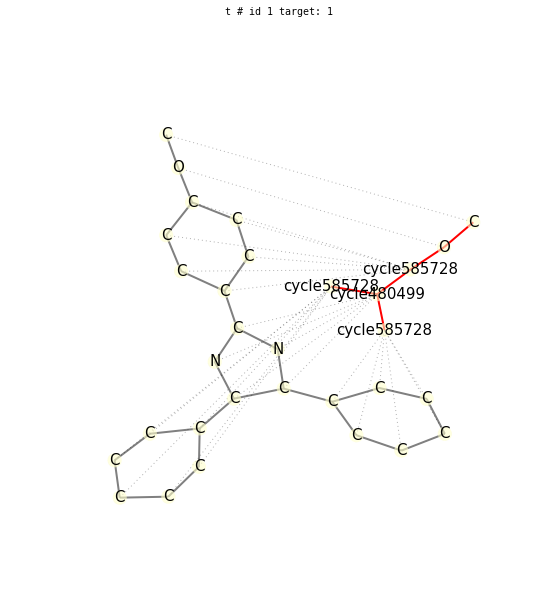

In [3]:
from graphlearn.utils import draw
import graphlearn.minor.molecule.transform_cycle as mole
import graphlearn.minor.decompose as decompose
from graphlearn.graphlearn import Sampler as GLS
from eden.graph import Vectorizer


decomposer = decompose.MinorDecomposer(Vectorizer(),include_base=False, base_thickness_list=[2])

#the preprocessor makes the abstraction, wrapper provides convenient format for drawing
preproc=mole.GraphTransformerCircles()
# get a graph and prepare it
graphs=get_graphs()
g=graphs.next()
graph_wrapper=decomposer.make_new_decomposer(Vectorizer(),preproc.wrap(g))
graph=graph_wrapper.pre_vectorizer_graph(nested=True)

# draw 
draw.graphlearn(graph,size=10, abstract_color='red', contract=True,ignore_for_layout='nesting')

# Generating a Sampler that uses GraphMinors

There are no modifications made to the sampler.
Just new decomposer and graphtransformer parameters are given.

In [4]:
%%time

from graphlearn.graphlearn import Sampler as graphlearn_sampler
graphs = get_graphs(size=500)
sampler=graphlearn_sampler(
            decomposer=decomposer,
            graphtransformer=transform.GraphMinorTransformer(
                                   core_shape_cluster =ShapeCluster(),
                                   name_cluster       =MiniBatchKMeans(n_clusters=6), 
                                   save_graphclusters =True),
            
            n_samples=5,
            batch_size=1,
            n_steps=50,
            n_jobs=1,
            quick_skip_orig_cip=False,
            probabilistic_core_choice=True,
            burnin=0,
            improving_threshold=0.5,
            select_cip_max_tries=100,
            keep_duplicates=True,
            include_seed=True )

sampler.fit(graphs,grammar_n_jobs=NJOBS)
print 'done'


Classifier:
SGDClassifier(alpha=0.000123720099728, average=False, class_weight=None,
       epsilon=0.1, eta0=0.527192864435, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=88, n_jobs=1,
       penalty='elasticnet', power_t=0.164113977597, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000
learning abstraction: 1740 partial graphs found
num clusters: 5
class: 0 count:461 (0.26)
class: 1 count:576 (0.33)
class: 2 count:111 (0.06)
class: 3 count:331 (0.19)
class: 4 count:161 (0.09)
class: 5 count:100 (0.06)



/usr/local/lib/python2.7/dist-packages/sklearn/calibration.py:414: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/usr/local/lib/python2.7/dist-packages/sklearn/calibration.py:424: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/usr/local/lib/python2.7/dist-packages/sklearn/calibration.py:426: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)



Classifier:
SGDClassifier(alpha=0.000757275033107, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0631889800426, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', n_iter=95,
       n_jobs=1, penalty='l2', power_t=0.640019381276, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000
#instances: 500  #interfaces: 271   #cores: 189   #core-interface-pairs: 936
done
CPU times: user 3min 24s, sys: 1.63 s, total: 3min 26s
Wall time: 3min 44s


# Inspect the induced grammar

The first graph in each line shows the minor graph of the first CIP.
note that the minor-interfacegraph is the same for all CIPs, while the minor-core might be different.

interface id: 353772 [35 options]


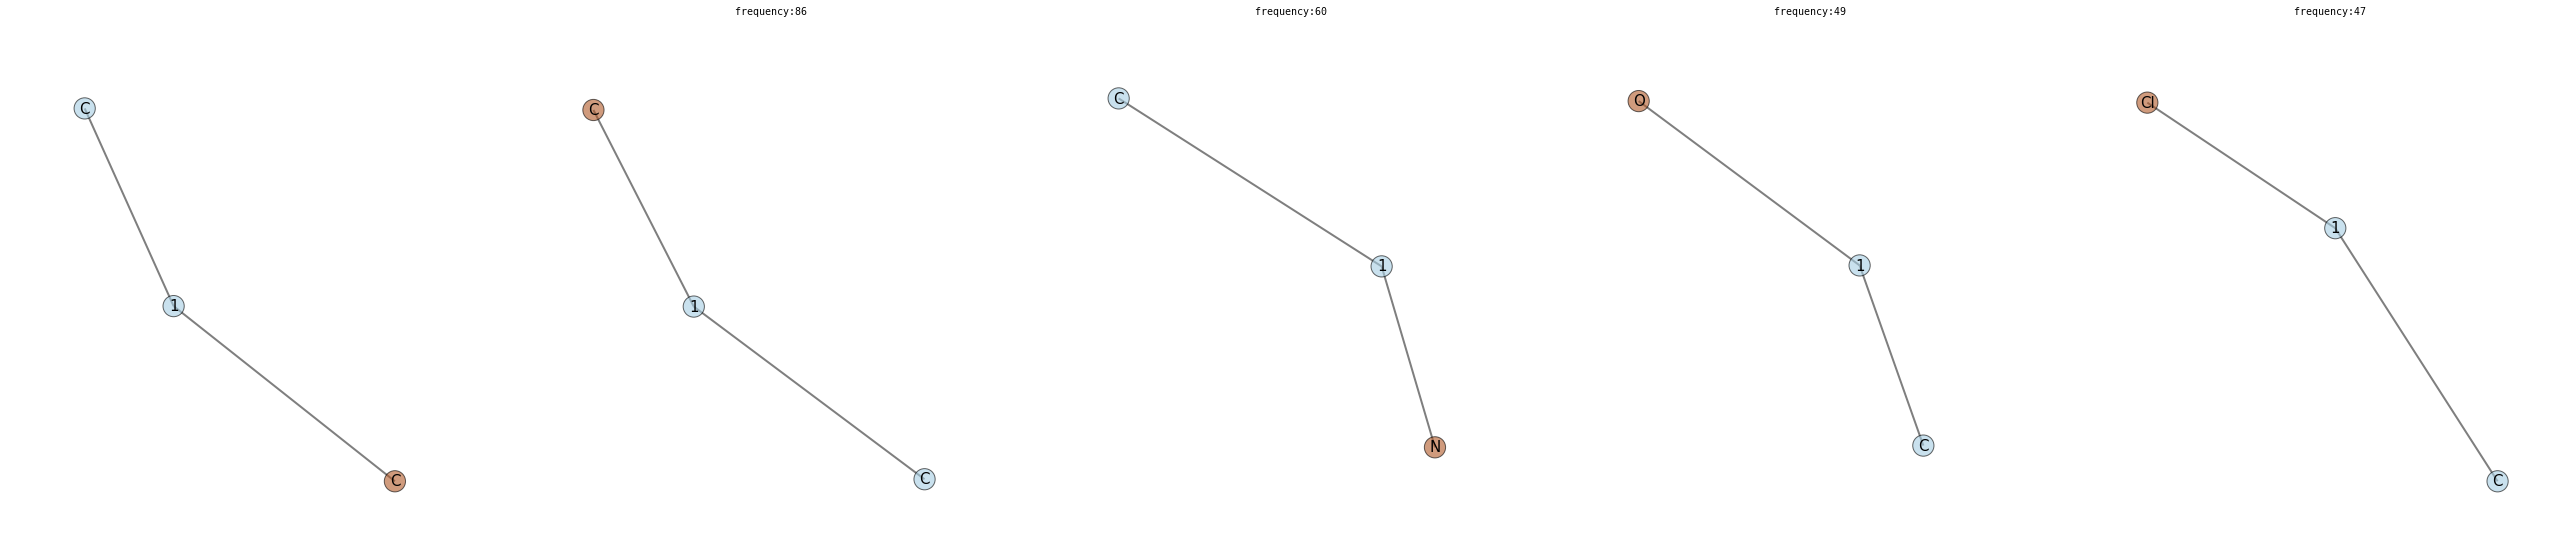

interface id: 53612 [20 options]


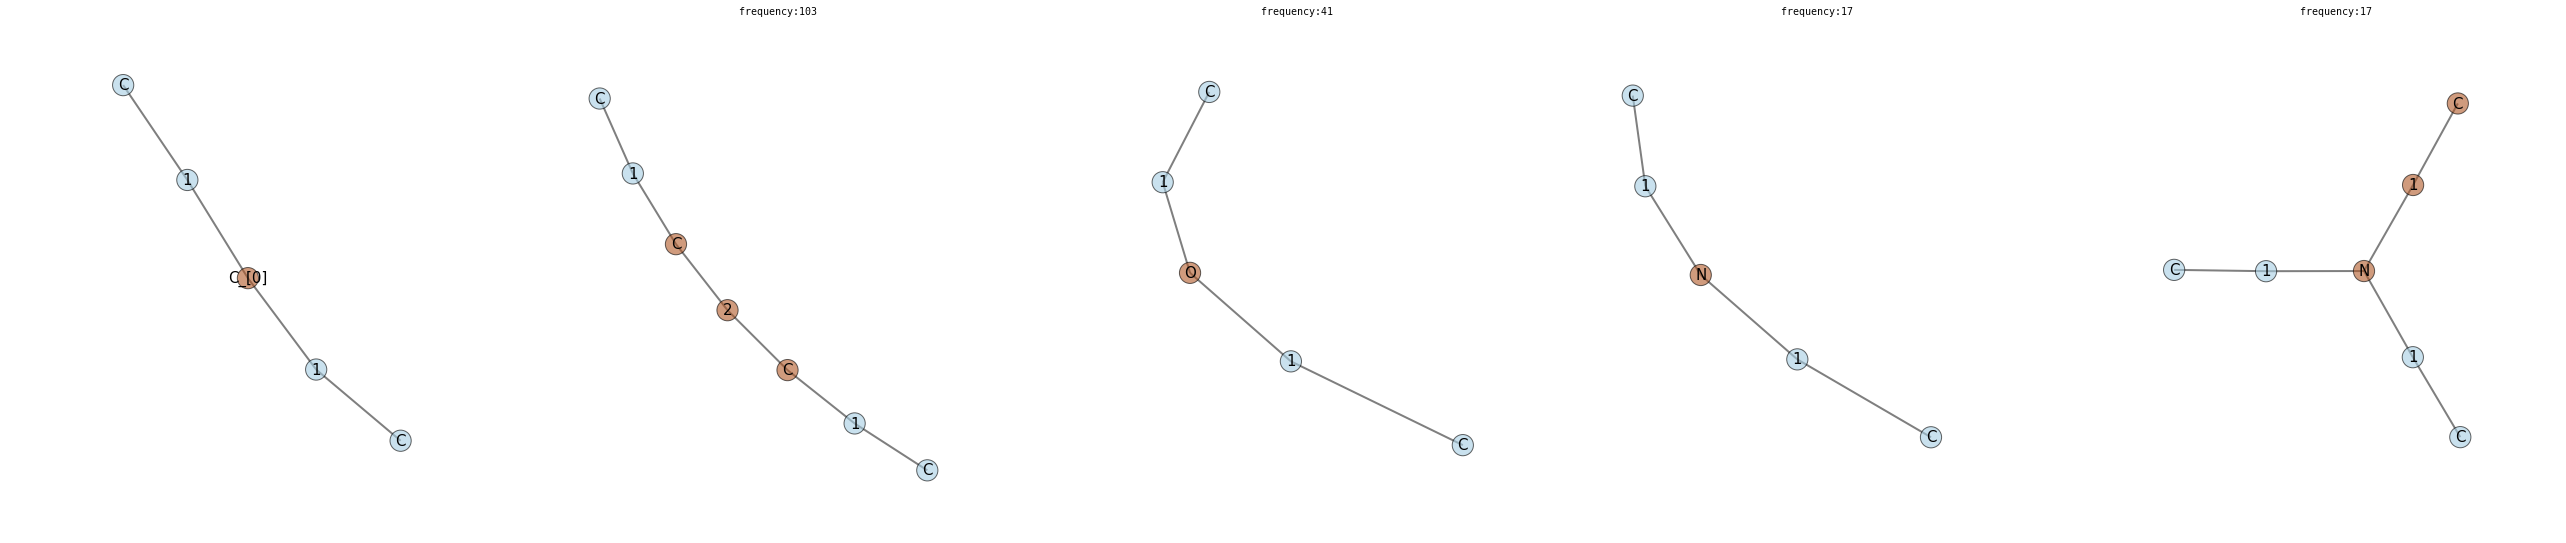

interface id: 199096 [16 options]


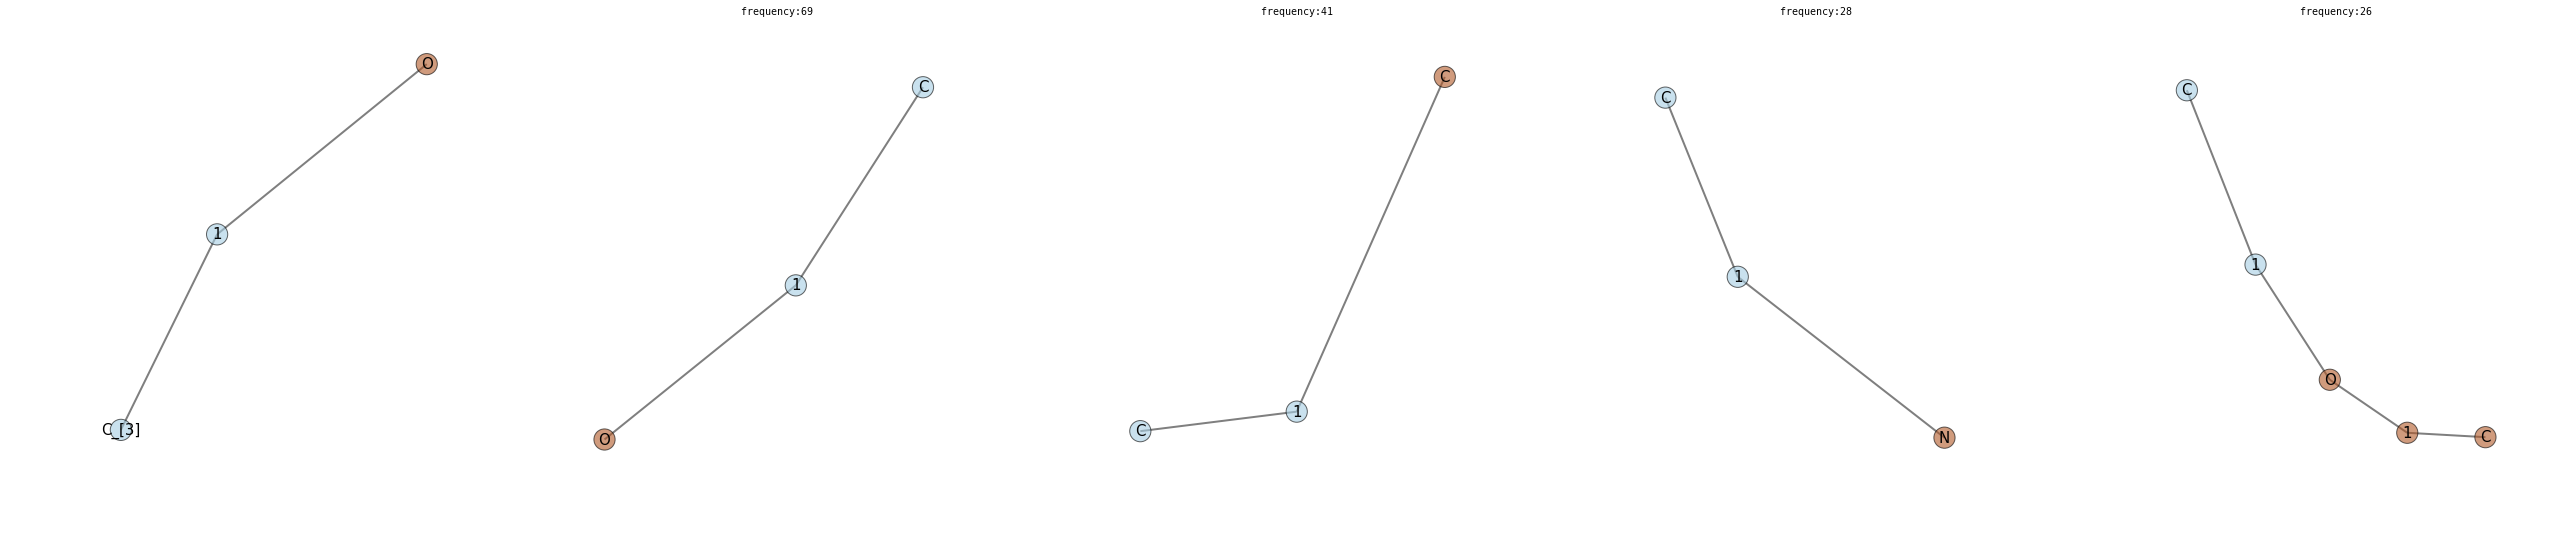

In [5]:
draw.draw_grammar(sampler.lsgg.productions,n_productions=3,n_graphs_per_production=5,
                     n_graphs_per_line=5, size=9, contract=False,
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.5, node_size=450, abstract_interface=True)

# sample molecules

Sampling works exactly the same way as before.

preprocessing grammar
accept_min_similarity: 0.0
accept_static_penalty: 0.0
batch_size: 1
    burnin: 0
decomposer: no graphs in decomposer
estimatorobject: <graphlearn.estimate.OneClassEstimator instance at 0x7fd57416b248>
feasibility_checker: <graphlearn.feasibility.FeasibilityChecker instance at 0x7fd57416b200>
graphtransformer: <graphlearn.minor.transform.GraphMinorTransformer object at 0x7fd54f42da10>
improving_linear_start: 0
improving_penalty_per_step: 2.0
improving_threshold: 25
include_seed: True
keep_duplicates: True
      lsgg: <graphlearn.localsubstitutablegraphgrammar.LocalSubstitutableGraphGrammar object at 0x7fd549515190>
maxbacktrack: 0
   monitor: False
  monitors: []
    n_jobs: 1
 n_samples: 5
   n_steps: 50
orig_cip_max_positives: 1
orig_cip_min_positives: 0
orig_cip_score_tricks: False
probabilistic_core_choice: True
proposal_probability: False
quick_skip_orig_cip: False
random_state: None
sampling_interval: 10
score_core_choice: False
select_cip_max_tries: 100
sim

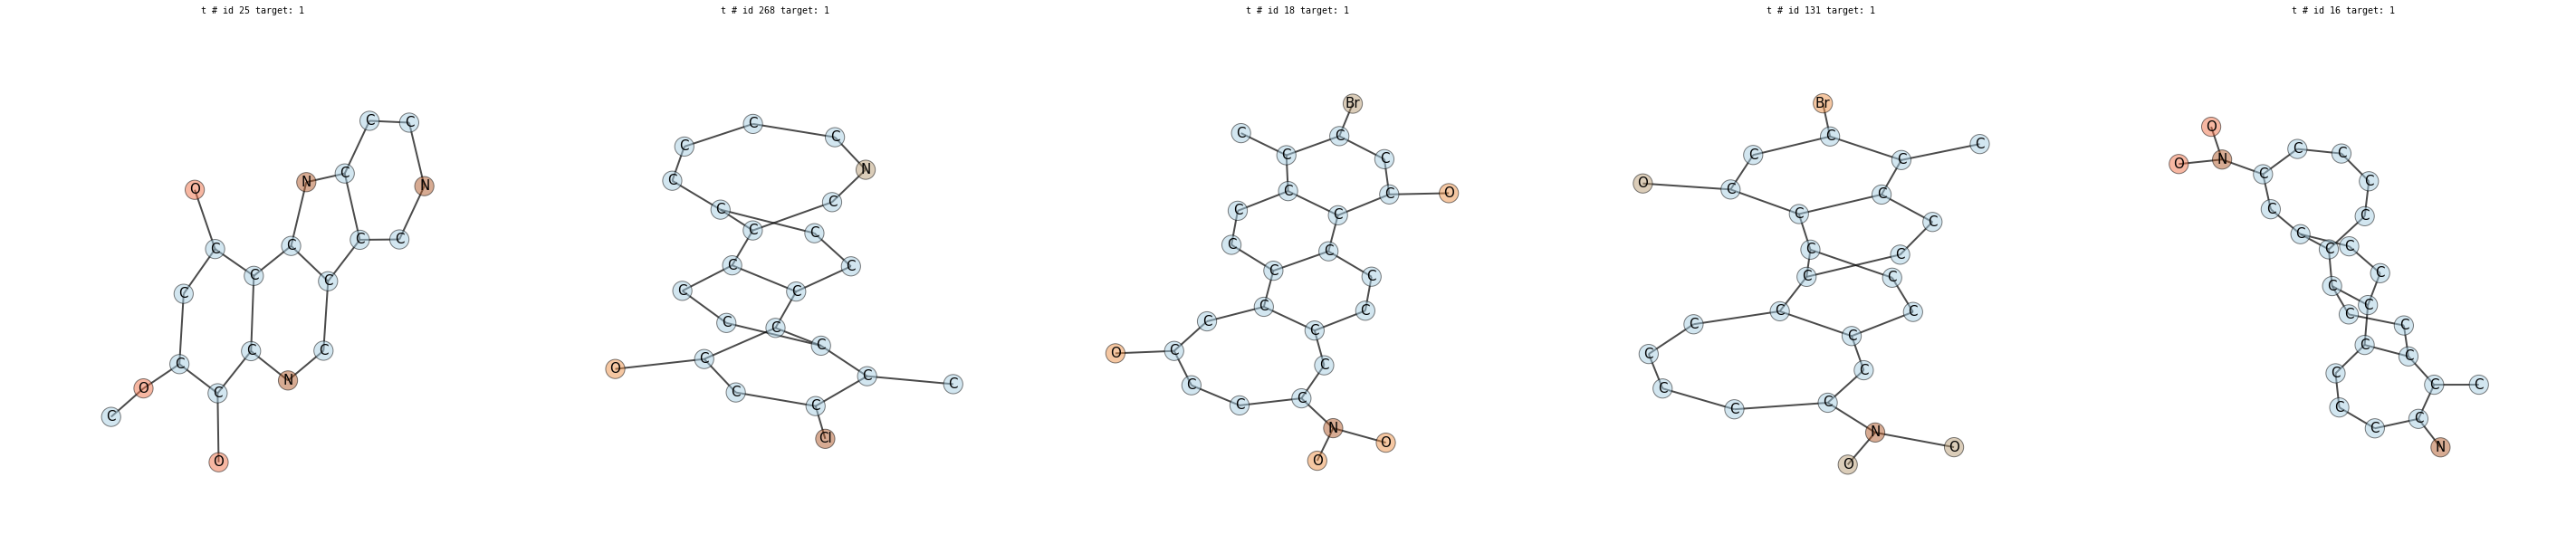

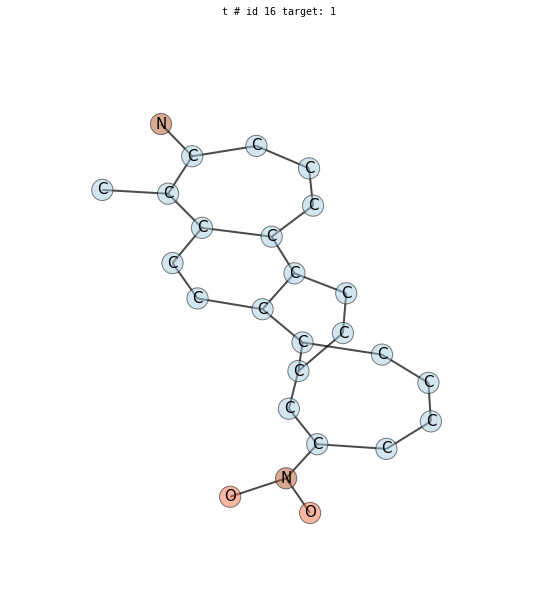

_propose_graph: iteration 0 ; core 0 of 12 ; original_cips tried  0 ; size 29
_propose_graph: iteration 1 ; core 0 of 5 ; original_cips tried  0 ; size 31
_propose_graph: iteration 2 ; core 0 of 5 ; original_cips tried  0 ; size 31
_propose_graph: iteration 3 ; core 0 of 1 ; original_cips tried  0 ; size 31
_propose_graph: iteration 4 ; core 0 of 5 ; original_cips tried  0 ; size 31
_propose_graph: iteration 5 ; core 0 of 5 ; original_cips tried  0 ; size 33
_propose_graph: iteration 6 ; core 0 of 1 ; original_cips tried  0 ; size 33
_propose_graph: iteration 7 ; core 0 of 5 ; original_cips tried  0 ; size 33
_propose_graph: iteration 8 ; core 0 of 1 ; original_cips tried  0 ; size 33
_propose_graph: iteration 9 ; core 0 of 3 ; original_cips tried  0 ; size 33
_propose_graph: iteration 10 ; core 0 of 1 ; original_cips tried  0 ; size 33
_propose_graph: iteration 11 ; core 0 of 1 ; original_cips tried  0 ; size 33
_propose_graph: iteration 12 ; core 0 of 1 ; original_cips tried  0 ; siz

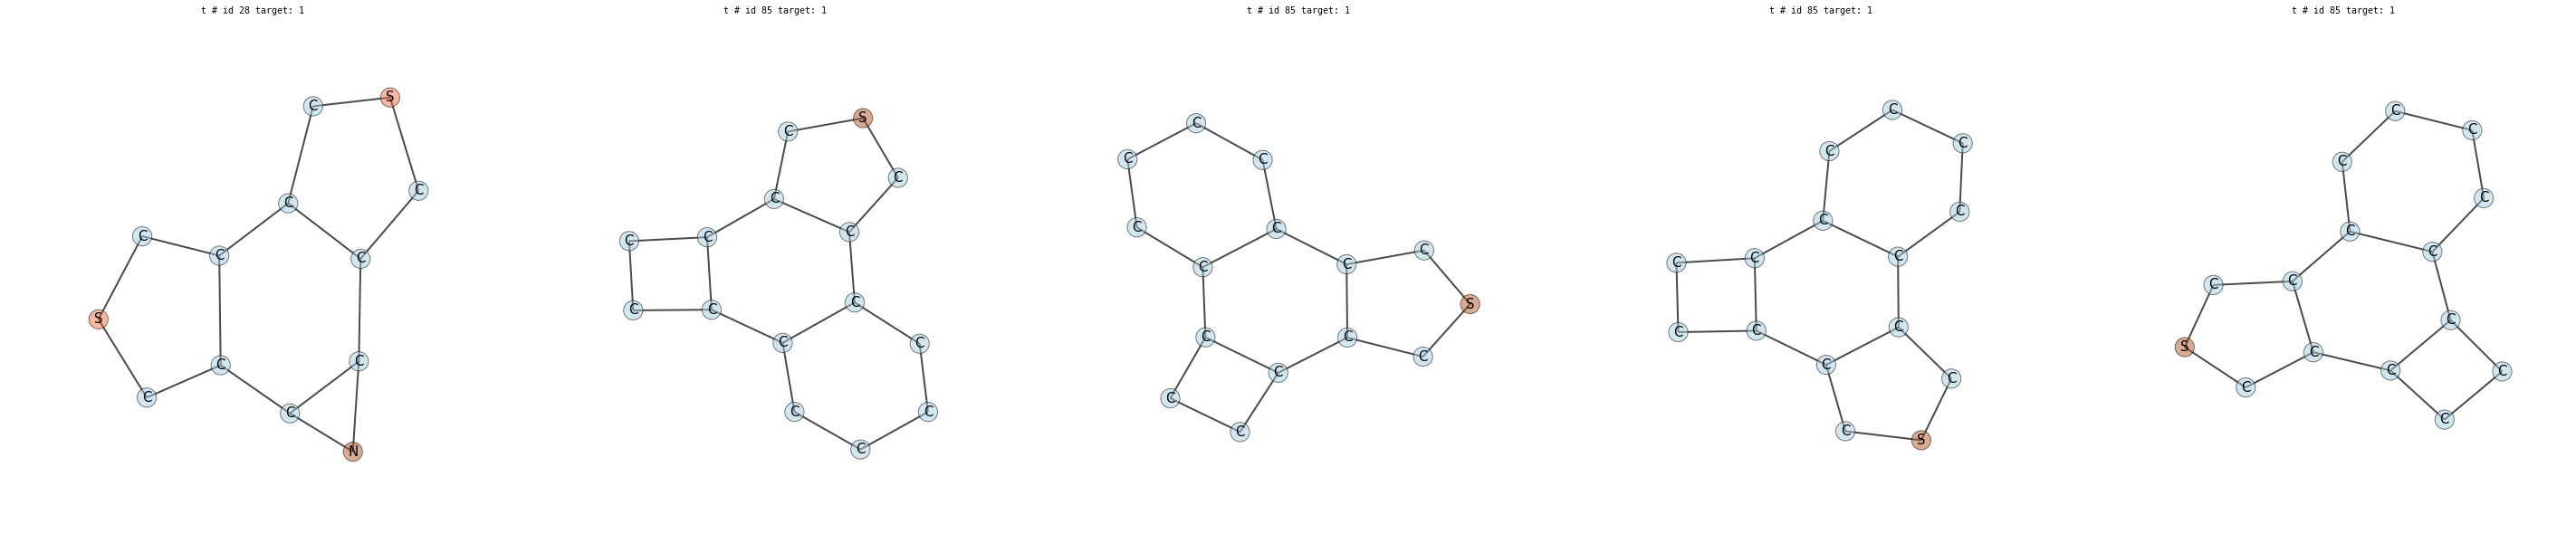

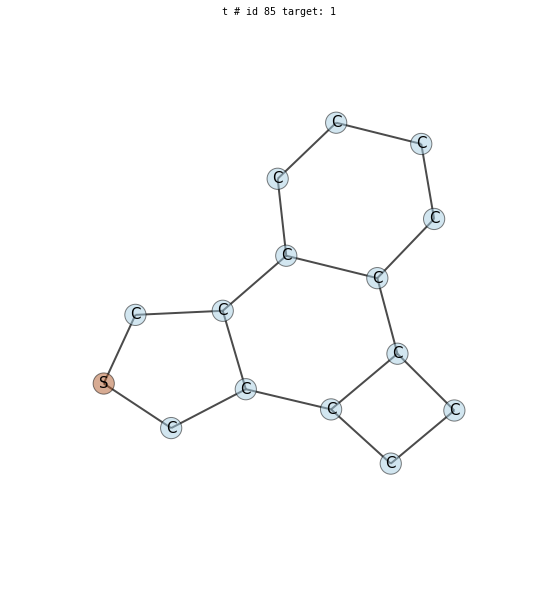

_propose_graph: iteration 0 ; core 0 of 34 ; original_cips tried  0 ; size 35
_propose_graph: iteration 1 ; core 0 of 1 ; original_cips tried  0 ; size 16
_propose_graph: iteration 2 ; core 0 of 13 ; original_cips tried  0 ; size 20
_propose_graph: iteration 3 ; core 0 of 7 ; original_cips tried  0 ; size 20
_propose_graph: iteration 4 ; core 0 of 34 ; original_cips tried  0 ; size 20
_propose_graph: iteration 5 ; core 0 of 1 ; original_cips tried  0 ; size 20
_propose_graph: iteration 6 ; core 0 of 1 ; original_cips tried  0 ; size 20
_propose_graph: iteration 7 ; core 0 of 7 ; original_cips tried  0 ; size 20
_propose_graph: iteration 8 ; core 0 of 10 ; original_cips tried  0 ; size 16
_propose_graph: iteration 9 ; core 0 of 9 ; original_cips tried  0 ; size 16
_propose_graph: iteration 10 ; core 0 of 13 ; original_cips tried  0 ; size 16
_propose_graph: iteration 11 ; core 0 of 34 ; original_cips tried  0 ; size 18
_propose_graph: iteration 12 ; core 0 of 19 ; original_cips tried  0

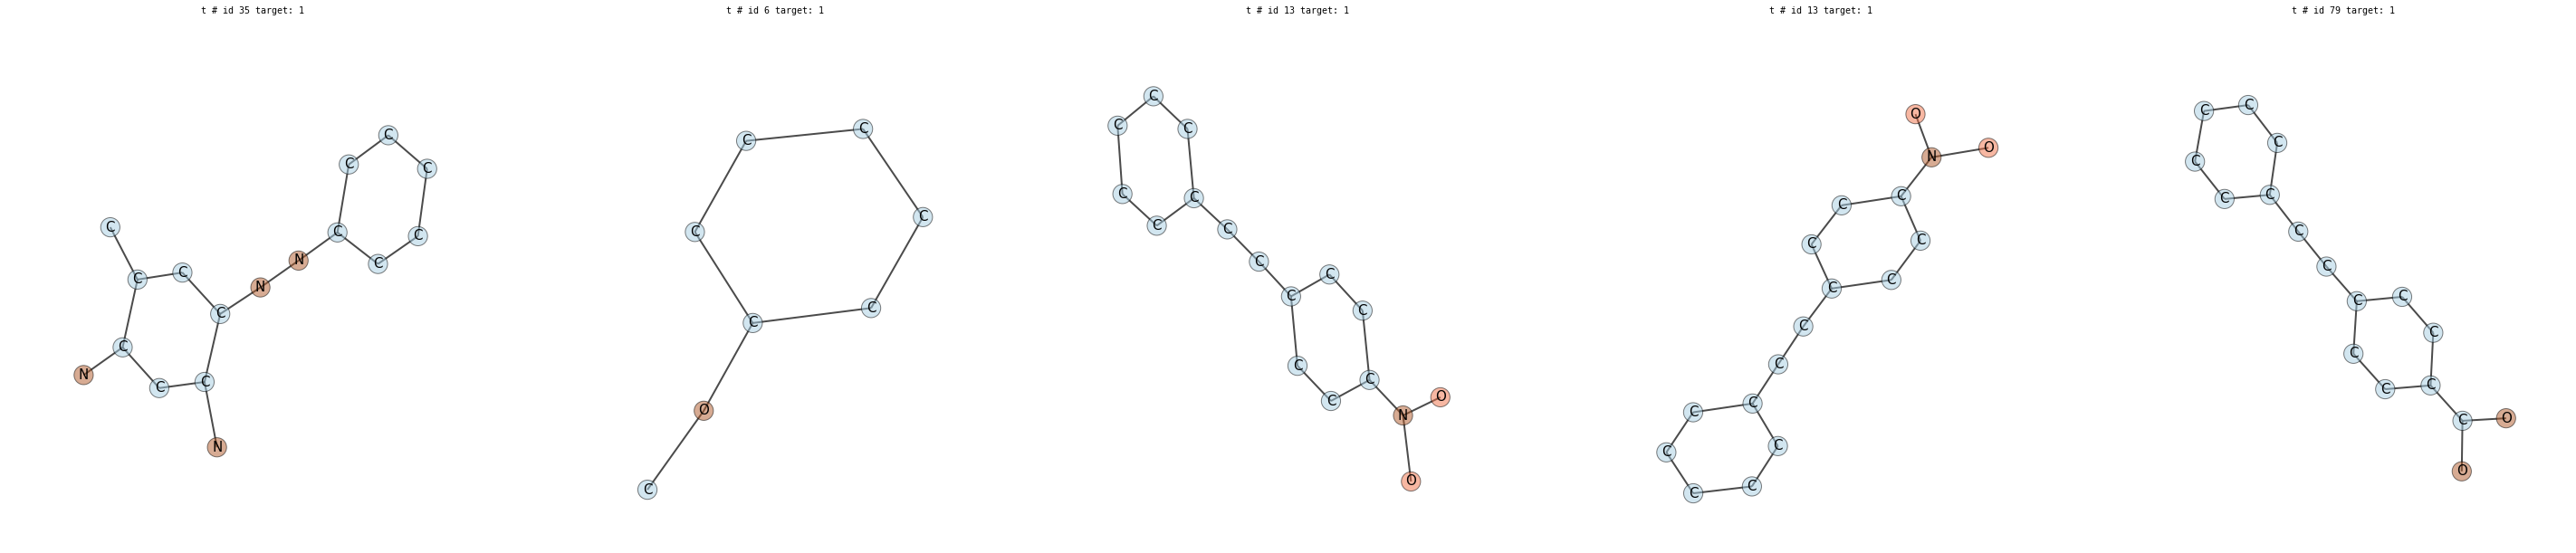

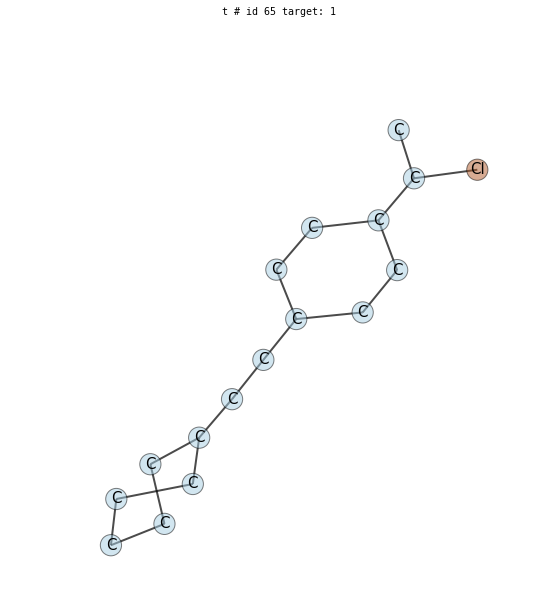

_propose_graph: iteration 0 ; core 0 of 5 ; original_cips tried  0 ; size 35
_propose_graph: iteration 1 ; core 0 of 2 ; original_cips tried  0 ; size 33
_propose_graph: iteration 2 ; core 0 of 2 ; original_cips tried  0 ; size 33
_propose_graph: iteration 3 ; core 0 of 2 ; original_cips tried  0 ; size 33
_propose_graph: iteration 4 ; core 0 of 2 ; original_cips tried  0 ; size 33
_propose_graph: iteration 5 ; core 0 of 1 ; original_cips tried  0 ; size 33
_propose_graph: iteration 6 ; core 0 of 2 ; original_cips tried  0 ; size 33
_propose_graph: iteration 7 ; core 0 of 2 ; original_cips tried  0 ; size 33
_propose_graph: iteration 8 ; core 0 of 2 ; original_cips tried  0 ; size 33
_propose_graph: iteration 9 ; core 0 of 2 ; original_cips tried  0 ; size 33
_propose_graph: iteration 10 ; core 0 of 2 ; original_cips tried  0 ; size 33
_propose_graph: iteration 11 ; core 0 of 2 ; original_cips tried  0 ; size 33
_propose_graph: iteration 12 ; core 0 of 2 ; original_cips tried  0 ; size

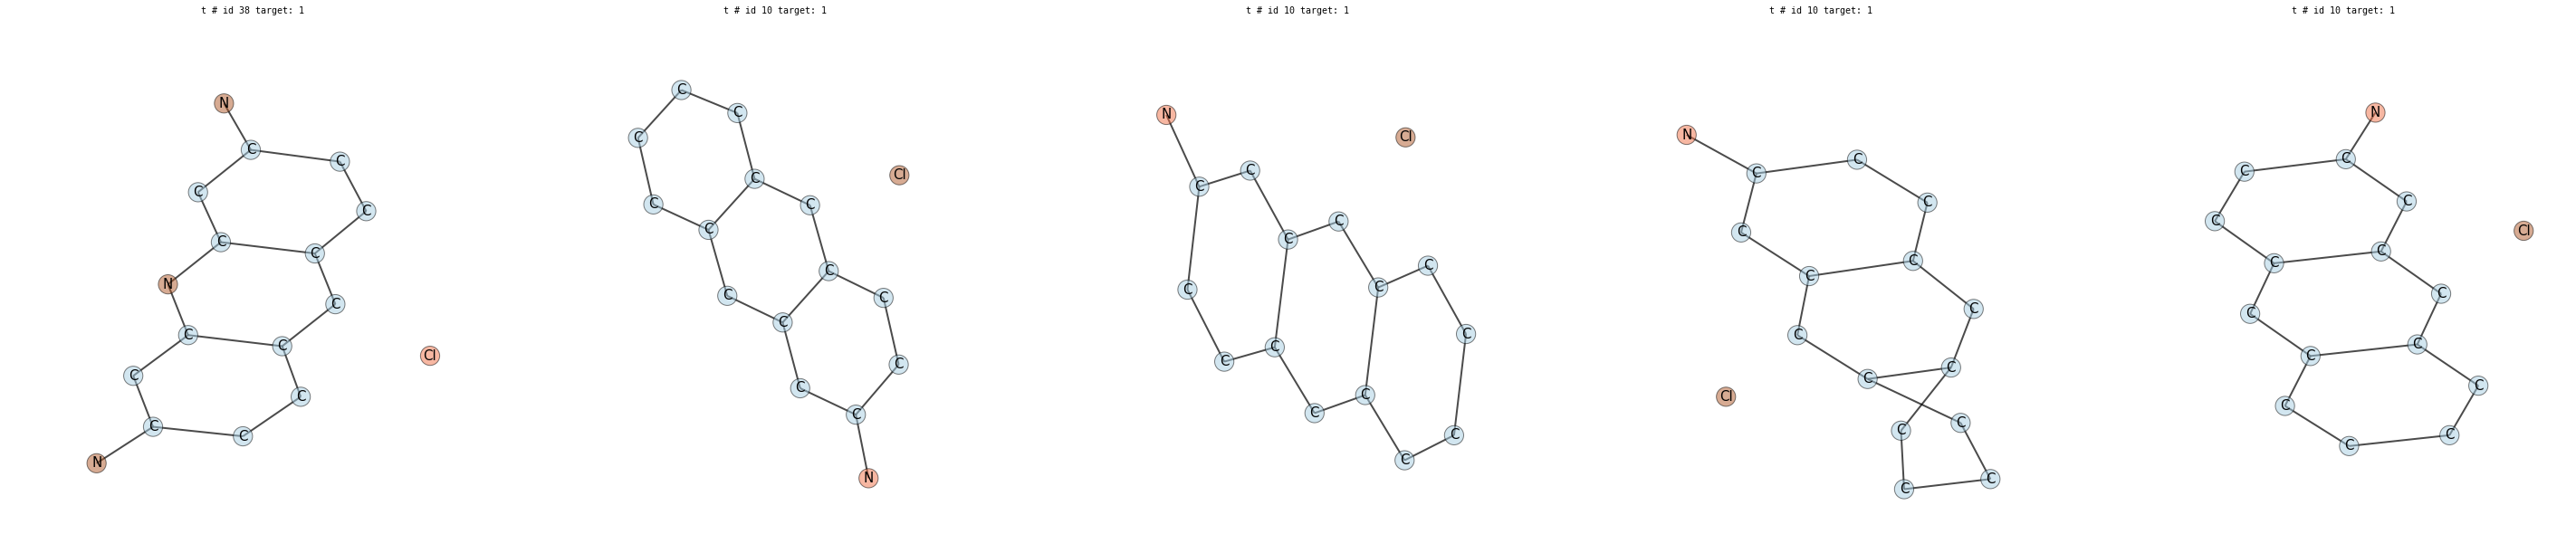

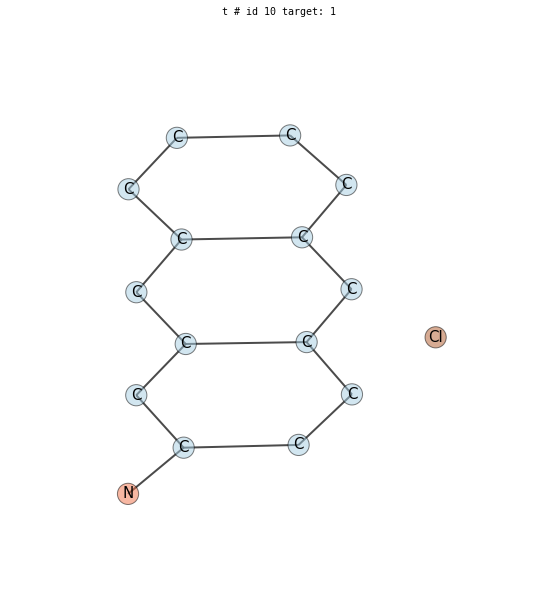

_propose_graph: iteration 0 ; core 0 of 3 ; original_cips tried  0 ; size 32
_propose_graph: iteration 1 ; core 0 of 5 ; original_cips tried  0 ; size 34
_propose_graph: iteration 2 ; core 0 of 4 ; original_cips tried  0 ; size 26
_propose_graph: iteration 3 ; core 0 of 3 ; original_cips tried  0 ; size 26
_propose_graph: iteration 4 ; core 0 of 4 ; original_cips tried  0 ; size 26
_propose_graph: iteration 5 ; core 0 of 11 ; original_cips tried  0 ; size 30
_propose_graph: iteration 6 ; core 0 of 1 ; original_cips tried  0 ; size 26
_propose_graph: iteration 7 ; core 0 of 1 ; original_cips tried  0 ; size 26
_propose_graph: iteration 8 ; core 0 of 2 ; original_cips tried  0 ; size 26
_propose_graph: iteration 9 ; core 0 of 1 ; original_cips tried  0 ; size 26
_propose_graph: iteration 10 ; core 0 of 1 ; original_cips tried  0 ; size 26
_propose_graph: iteration 11 ; core 0 of 1 ; original_cips tried  0 ; size 26
_propose_graph: iteration 12 ; core 0 of 2 ; original_cips tried  0 ; siz

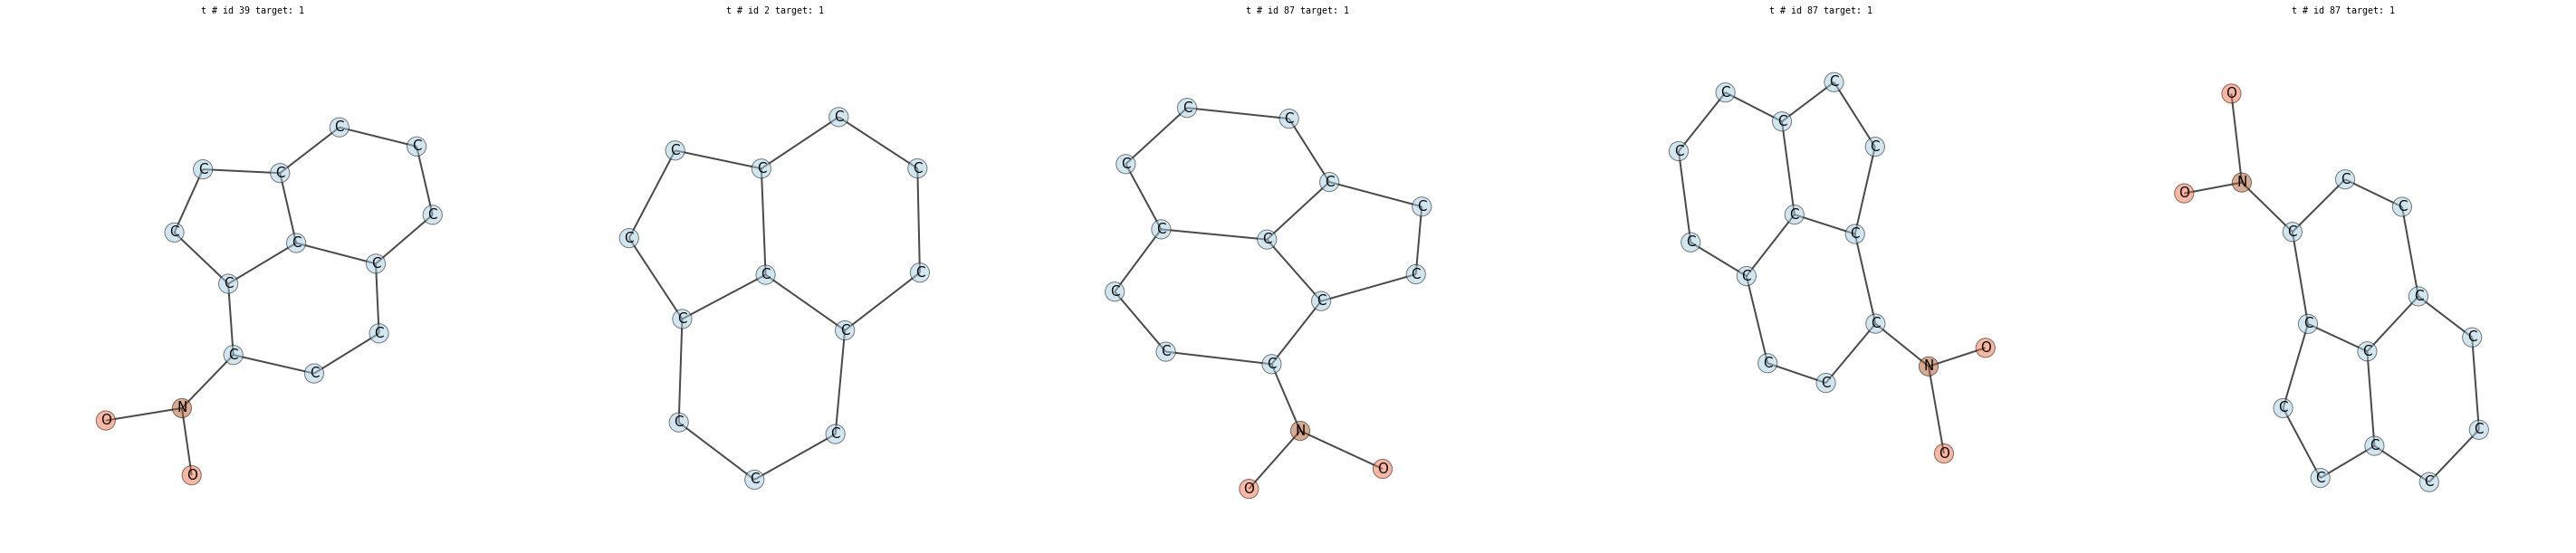

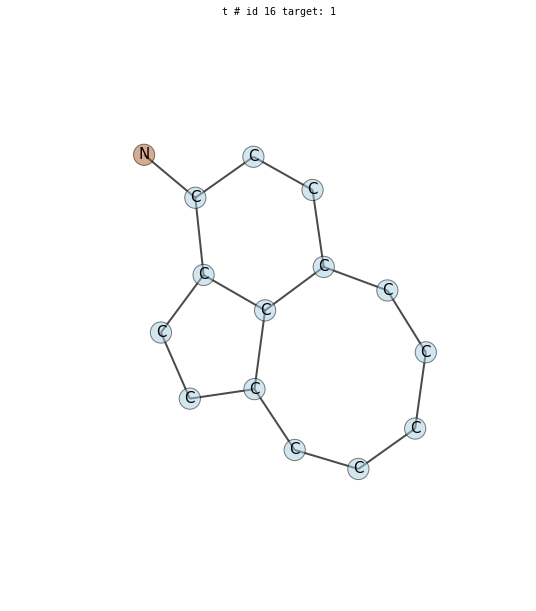

_propose_graph: iteration 0 ; core 0 of 15 ; original_cips tried  0 ; size 83
_propose_graph: iteration 1 ; core 0 of 1 ; original_cips tried  0 ; size 79
_propose_graph: iteration 2 ; core 0 of 15 ; original_cips tried  0 ; size 79
_propose_graph: iteration 3 ; core 0 of 1 ; original_cips tried  0 ; size 81
_propose_graph: iteration 4 ; core 0 of 1 ; original_cips tried  0 ; size 81
_propose_graph: iteration 5 ; core 0 of 4 ; original_cips tried  0 ; size 79
_propose_graph: iteration 6 ; core 0 of 15 ; original_cips tried  0 ; size 83
_propose_graph: iteration 7 ; core 0 of 1 ; original_cips tried  0 ; size 83
_propose_graph: iteration 8 ; core 0 of 12 ; original_cips tried  0 ; size 83
_propose_graph: iteration 9 ; core 0 of 1 ; original_cips tried  0 ; size 83
_propose_graph: iteration 10 ; core 0 of 15 ; original_cips tried  0 ; size 83
_propose_graph: iteration 11 ; core 0 of 12 ; original_cips tried  0 ; size 83
_propose_graph: iteration 12 ; core 0 of 12 ; original_cips tried  0

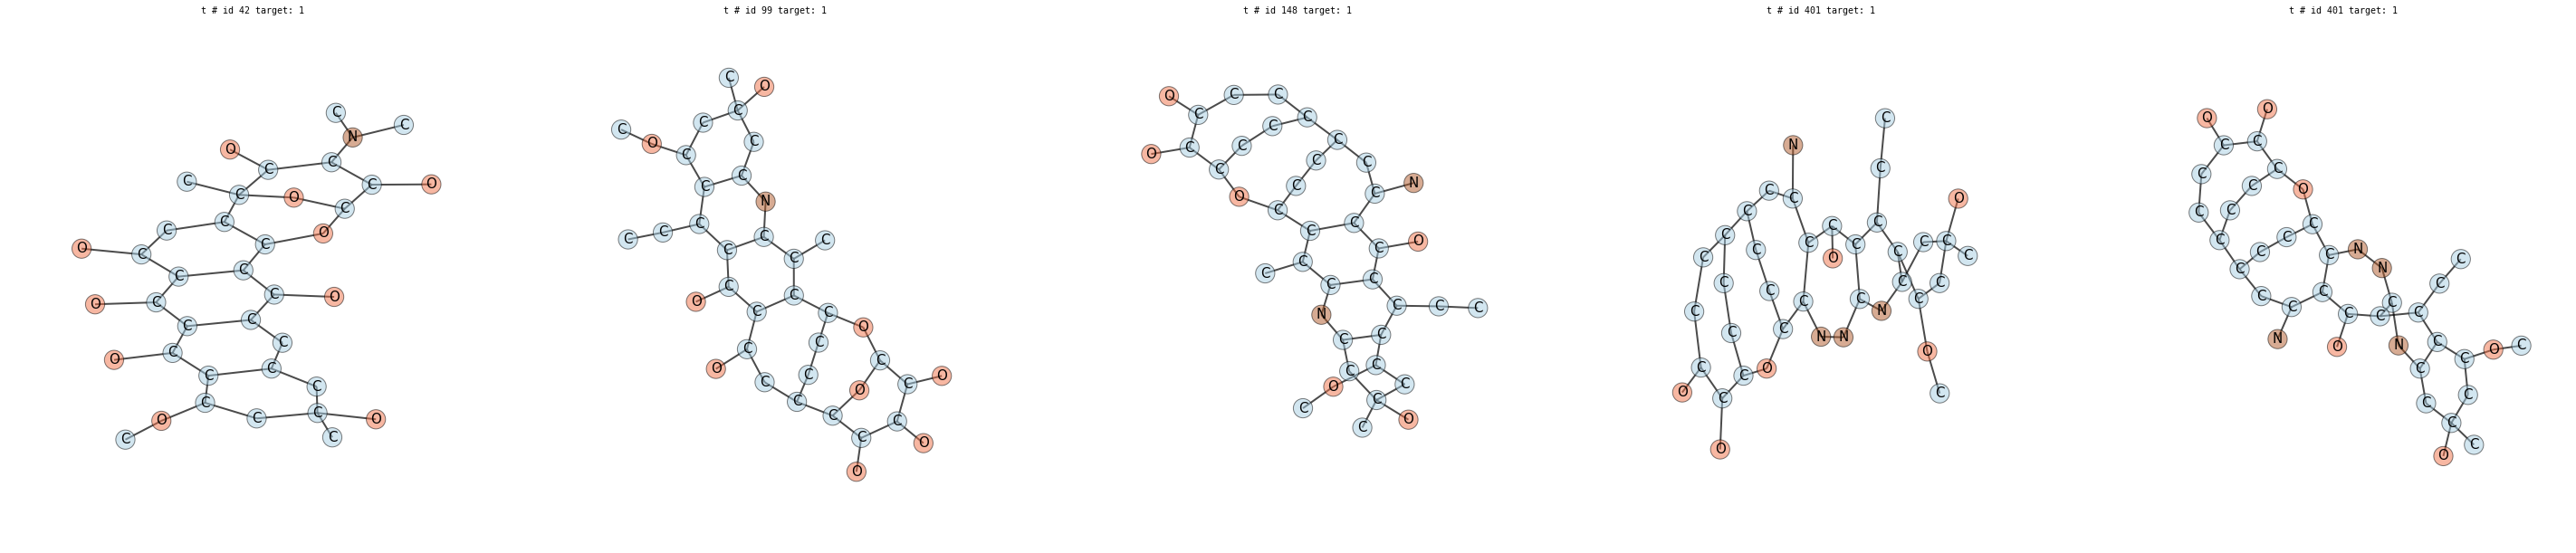

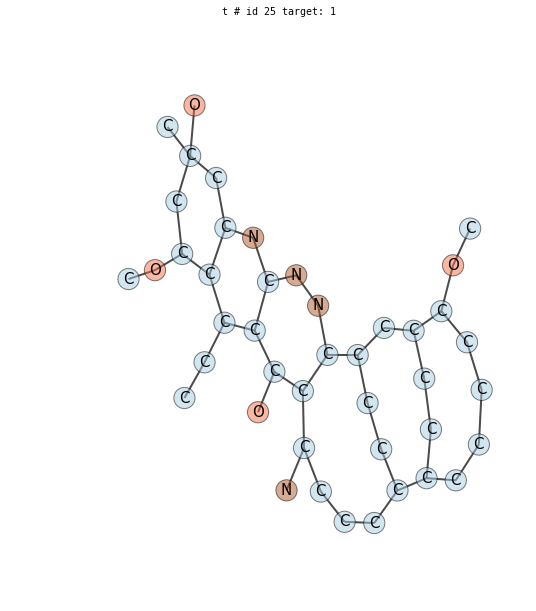

_propose_graph: iteration 0 ; core 0 of 11 ; original_cips tried  0 ; size 37
_propose_graph: iteration 1 ; core 0 of 1 ; original_cips tried  0 ; size 31
_propose_graph: iteration 2 ; core 0 of 19 ; original_cips tried  0 ; size 31
_propose_graph: iteration 3 ; core 0 of 1 ; original_cips tried  0 ; size 31
_propose_graph: iteration 4 ; core 0 of 19 ; original_cips tried  0 ; size 31
_propose_graph: iteration 5 ; core 0 of 11 ; original_cips tried  0 ; size 31
_propose_graph: iteration 6 ; core 0 of 11 ; original_cips tried  0 ; size 31
_propose_graph: iteration 7 ; core 0 of 11 ; original_cips tried  0 ; size 31
_propose_graph: iteration 8 ; core 0 of 13 ; original_cips tried  0 ; size 27
_propose_graph: iteration 9 ; core 0 of 34 ; original_cips tried  0 ; size 27
_propose_graph: iteration 10 ; core 0 of 1 ; original_cips tried  0 ; size 27
_propose_graph: iteration 11 ; core 0 of 1 ; original_cips tried  0 ; size 27
_propose_graph: iteration 12 ; core 0 of 1 ; original_cips tried  

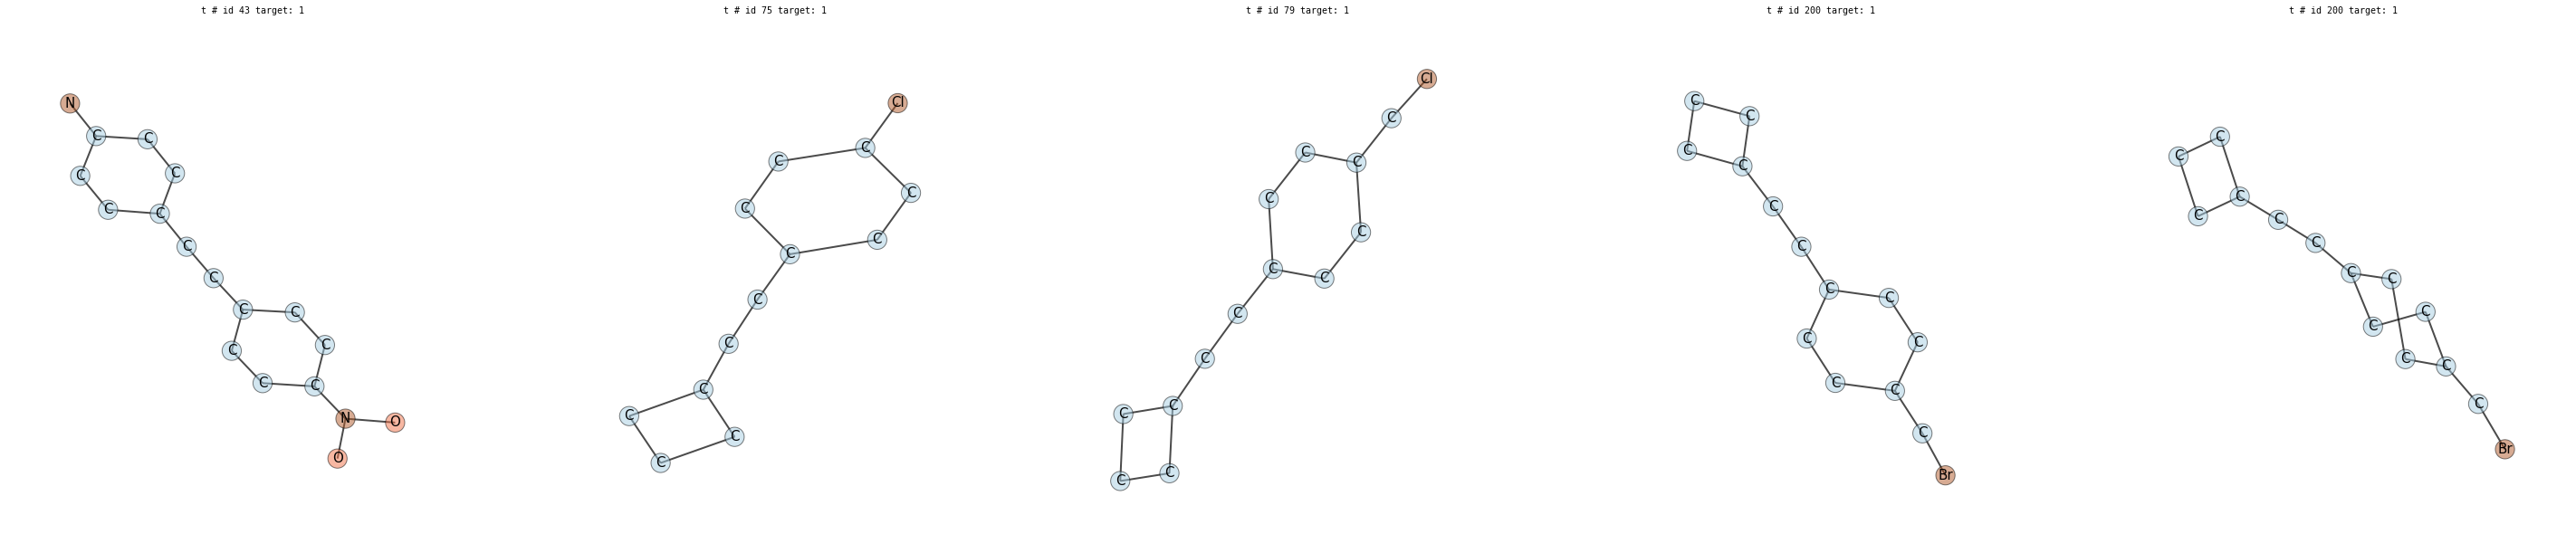

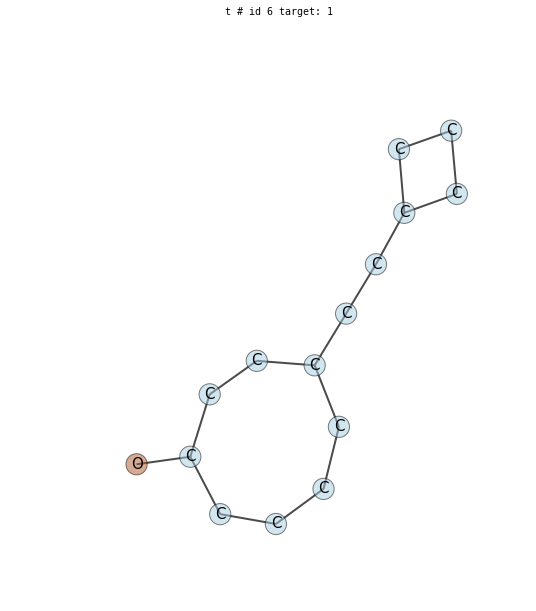

_propose_graph: iteration 0 ; core 0 of 1 ; original_cips tried  0 ; size 32
_propose_graph: iteration 1 ; core 0 of 34 ; original_cips tried  0 ; size 32
_propose_graph: iteration 2 ; core 0 of 6 ; original_cips tried  0 ; size 32
_propose_graph: iteration 3 ; core 0 of 5 ; original_cips tried  0 ; size 32
_propose_graph: iteration 4 ; core 0 of 3 ; original_cips tried  0 ; size 32
_propose_graph: iteration 5 ; core 0 of 6 ; original_cips tried  0 ; size 32
_propose_graph: iteration 6 ; core 0 of 6 ; original_cips tried  0 ; size 32
_propose_graph: iteration 7 ; core 0 of 5 ; original_cips tried  0 ; size 32
_propose_graph: iteration 8 ; core 0 of 4 ; original_cips tried  0 ; size 32
_propose_graph: iteration 9 ; core 0 of 5 ; original_cips tried  0 ; size 32
_propose_graph: iteration 10 ; core 0 of 5 ; original_cips tried  0 ; size 24
_propose_graph: iteration 11 ; core 0 of 3 ; original_cips tried  0 ; size 24
_propose_graph: iteration 12 ; core 0 of 4 ; original_cips tried  0 ; siz

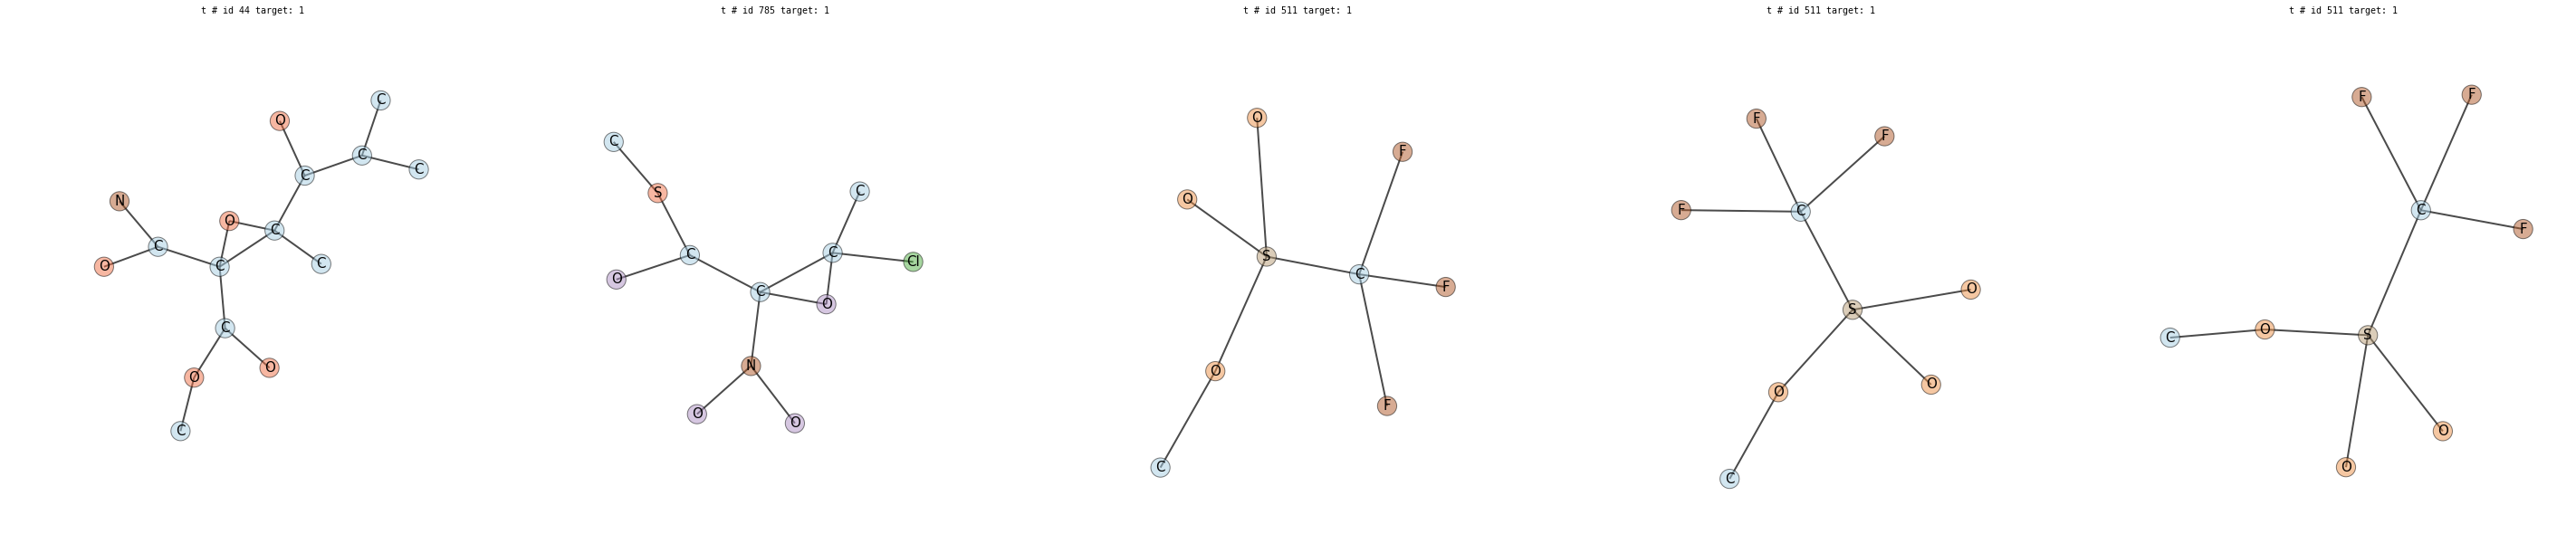

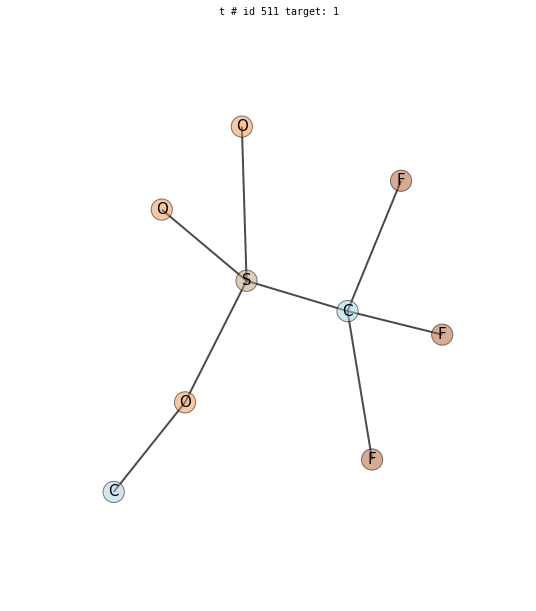

_propose_graph: iteration 0 ; core 0 of 8 ; original_cips tried  0 ; size 20
_propose_graph: iteration 1 ; core 0 of 1 ; original_cips tried  0 ; size 22
_propose_graph: iteration 2 ; core 0 of 6 ; original_cips tried  0 ; size 22
_propose_graph: iteration 3 ; core 0 of 5 ; original_cips tried  0 ; size 22
_propose_graph: iteration 4 ; core 0 of 1 ; original_cips tried  0 ; size 22
_propose_graph: iteration 5 ; core 0 of 8 ; original_cips tried  0 ; size 22
_propose_graph: iteration 6 ; core 0 of 34 ; original_cips tried  0 ; size 22
_propose_graph: iteration 7 ; core 0 of 5 ; original_cips tried  0 ; size 22
_propose_graph: iteration 8 ; core 0 of 6 ; original_cips tried  0 ; size 22
_propose_graph: iteration 9 ; core 0 of 13 ; original_cips tried  0 ; size 22
_propose_graph: iteration 10 ; core 0 of 3 ; original_cips tried  0 ; size 22
_propose_graph: iteration 11 ; core 0 of 8 ; original_cips tried  0 ; size 22
_propose_graph: iteration 12 ; core 0 of 3 ; original_cips tried  0 ; si

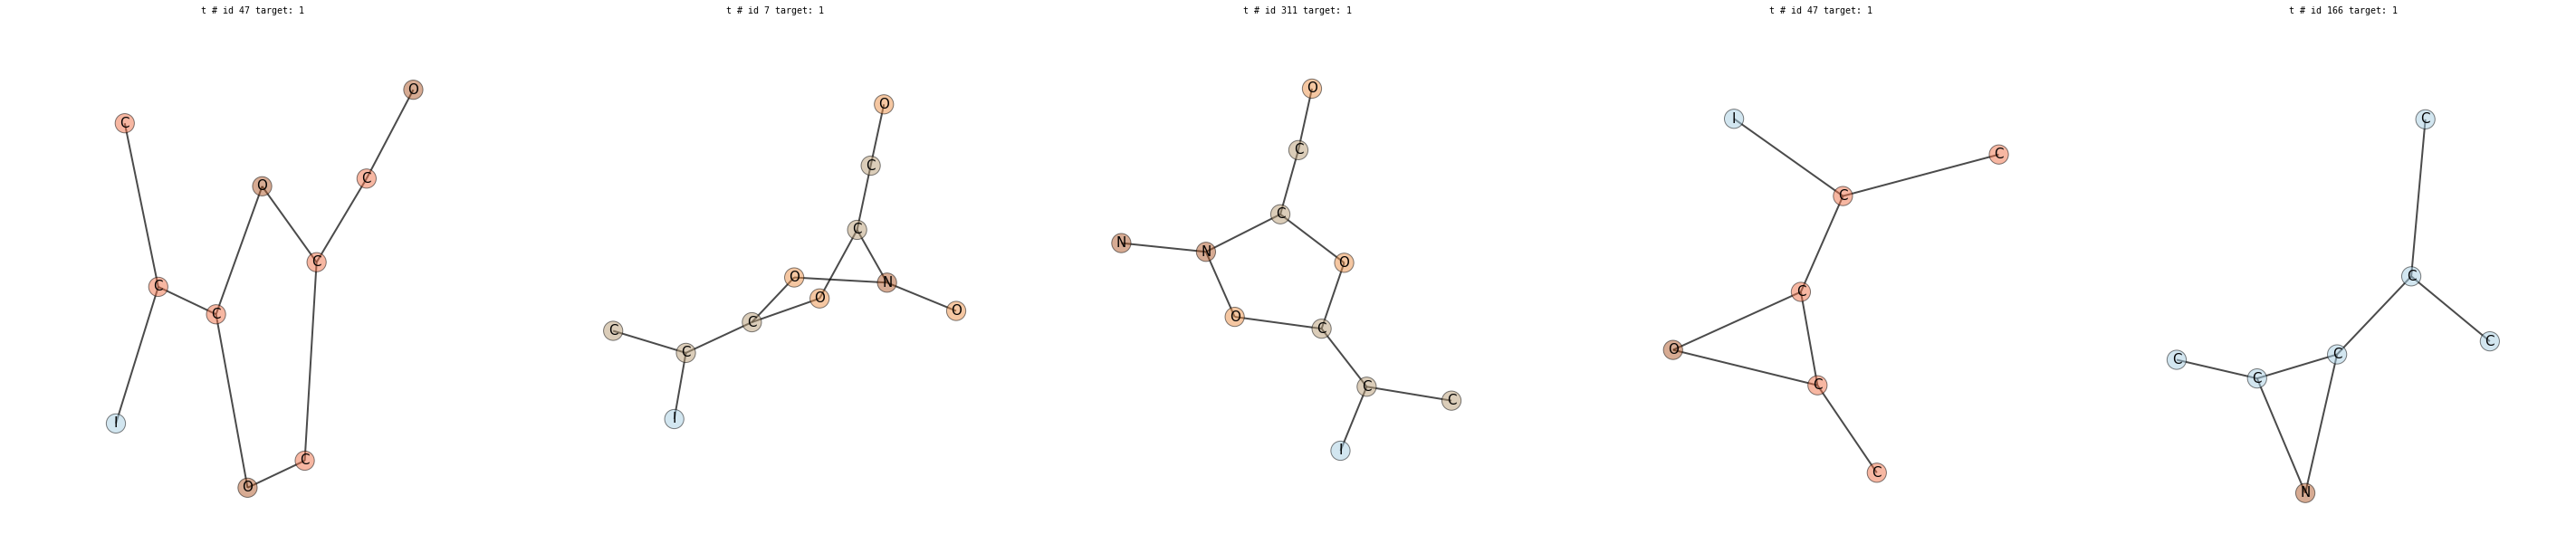

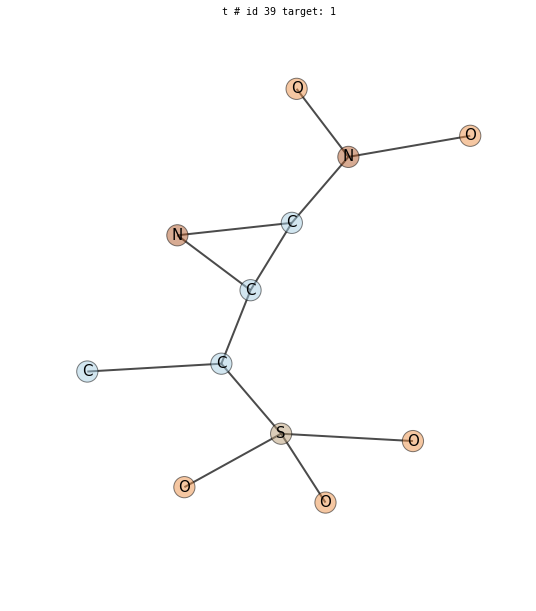

CPU times: user 39.1 s, sys: 1.26 s, total: 40.3 s
Wall time: 42.7 s


In [6]:
%%time
import graphlearn.utils.draw as draw
import itertools

#parameters
graphs = get_graphs()
id_start=15
id_end=id_start+9
graphs = itertools.islice(graphs,id_start,id_end)
n_steps=50


# sampling with many arguments.
graphs = sampler.transform(graphs)

 
    
scores=[]
ids=range(id_start,id_end)
for i,path_graphs in enumerate(graphs):
    # for each sampling path:
    print 'Graph id: %d'%(ids[i])
    
    #collect scores so that we can display the score graph later 
    scores.append(sampler.monitors[i].sampling_info['score_history'])
    
    # show graphs
    if True:
        draw.graphlearn(path_graphs,
                        n_graphs_per_line=5, size=10, 
                       colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='_label_',
                        vertex_alpha=0.5, edge_alpha=0.7, node_size=450)
    else:
        from graphlearn.utils import openbabel
        openbabel.draw(path_graphs)

## plot score graph

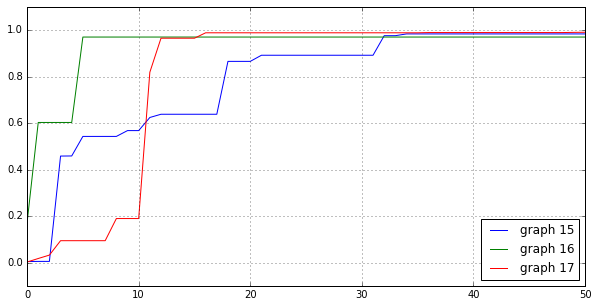

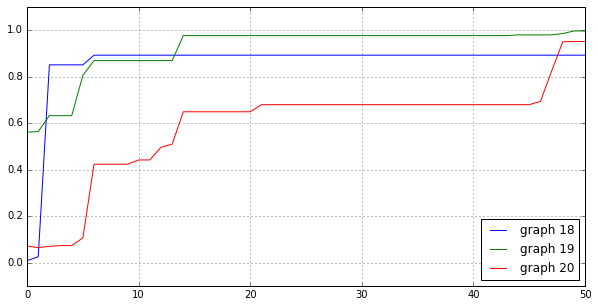

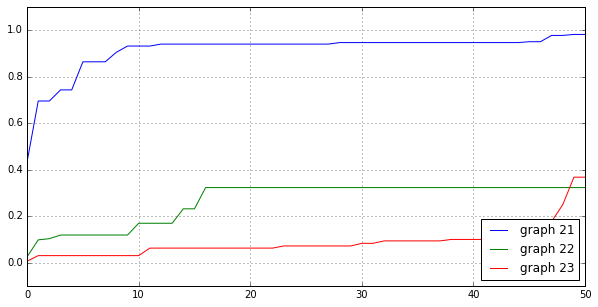

In [7]:
%matplotlib inline
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt

step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()

---